In [1]:
# install libraries
!pip install gymnasium  # Use gymnasium instead of gym for newer environments
!pip install torch  # Install PyTorch
!pip install matplotlib
!pip install ipython


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Core Python libraries
import random
import math
import time
from copy import deepcopy
from itertools import count
from collections import namedtuple, deque
import traceback

# Scientific computing
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
from IPython.display import display

# Environment
from gymnasium import Env
from gymnasium.spaces import Discrete, Box

# Optional (if used in your project)
# import pygame



In [101]:


class connect_4:

    def __init__(self):
        self.board_height = 6
        self.board_width = 7
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8) # 0 -> empty cell
        self.players = {'p1': 1, 'p2': 2} # 1, 2 are O and X respectively
        self.isDone = False
        self.valid_2 = False
        self.valid_3 = False

        # self.reward = {'win': 10, 'draw': 1, 'lose': -10}
        self.reward = {'win': 100, 'draw': 1, 'lose': -500, 'valid_2': 20, 'valid_3': 30}

        self.turn = 1

    def get_board(self):
        return deepcopy(self.board_state)

    def render(self):
        rendered_board_state = self.board_state.copy().astype(str)
        rendered_board_state[self.board_state == 0] = ' '
        rendered_board_state[self.board_state == 1] = 'O'
        rendered_board_state[self.board_state == 2] = 'X'
        display(pd.DataFrame(rendered_board_state))

    def reset(self):
        self.__init__()

    def get_available_actions(self):
        available_cols = []
        for j in range(self.board_width):
            if np.sum([self.board_state[:, j] == 0]) != 0:
                available_cols.append(j)
        return available_cols

    def check_game_done(self, player):
        if player == 'p1':
            check = '1 1 1 1'
            valid_2 = '1 1'
            valid_3 = '1 1 1'
        else:
            check = '2 2 2 2'
            valid_2 = '2 2'
            valid_3 = '2 2 2'

        # check vertically then horizontally
        for j in range(self.board_width):
            if check in np.array_str(self.board_state[:, j]):
                self.isDone = True
            # elif valid_3 in np.array_str(self.board_state[:, j]):
            #   self.valid_3 = True
            # elif valid_2 in np.array_str(self.board_state[:, j]):
            #   self.valid_2 = True
        for i in range(self.board_height):
            if check in np.array_str(self.board_state[i, :]):
                self.isDone = True
            # elif valid_3 in np.array_str(self.board_state[i, :]):
            #     self.valid_3 = True
            # elif valid_2 in np.array_str(self.board_state[i, :]):
            #     self.valid_2 = True

        # check left diagonal and right diagonal
        for k in range(0, self.board_height - 4 + 1):
            left_diagonal = np.array([self.board_state[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True
            # elif valid_3 in np.array_str(left_diagonal) or valid_3 in np.array_str(right_diagonal):
            #     self.valid_3 = True
            # elif valid_2 in np.array_str(left_diagonal) or valid_2 in np.array_str(right_diagonal):
            #     self.valid_2 = True
        for k in range(1, self.board_width - 4 + 1):
            left_diagonal = np.array([self.board_state[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                self.isDone = True
            # elif valid_3 in np.array_str(left_diagonal) or valid_3 in np.array_str(right_diagonal):
            #     self.valid_3 = True
            # elif valid_2 in np.array_str(left_diagonal) or valid_2 in np.array_str(right_diagonal):
            #     self.valid_2 = True

        if self.isDone:
            return self.reward['win']
        # elif self.valid_3:
        #     return self.reward['valid_3']
        # elif self.valid_2:
        #     return self.reward['valid_2']
        # check for draw
        elif np.sum([self.board_state == 0]) == 0:
            self.isDone = True
            print('draw')
            print('isDone set to true')
            return self.reward['draw']
        else:
            return 0 # not win, not draw
            # return self.reward['lose']

    def make_move(self, a, player):
        # check if move is valid
        if a in self.get_available_actions():
            i = np.sum([self.board_state[:, a] == 0]) - 1
            self.board_state[i, a] = self.players[player]
        else:
            print(f'a is {a} and player is {player}')
            print('Move is invalid')
            self.render()

        reward = self.check_game_done(player)

        # give feedback as new state and reward
        self.turn = 1+(self.turn%2)
        return self.board_state.copy(), reward


In [541]:


class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()
        # 6 by 7, 10 by 11
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(linear_input_size, 50)
        self.MLP2 = nn.Linear(50, 50)
        self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(50, outputs)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)


import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
from pennylane import numpy as np

# Define the quantum device and circuit
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))

    # shape_inner_temp = qml.StronglyEntanglingLayers.shape(n_layers=3, n_wires=n_qubits)
    # weights_inner_temp = np.random.random(size=shape_inner_temp)
    # print("weights_inner_temp:", weights_inner_temp.shape)

    # print("weights:", weights.shape)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    ret_val = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    # print("ret_val:", ret_val)
    return ret_val

# Wrap the quantum circuit into a PyTorch layer
class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_params = nn.Parameter(torch.randn((3, n_qubits, 3)))  # Shape from template docs

    def forward(self, x):
        # x: [batch_size, 4]  (we will ensure this shape)
        # print("x input:", x)

        outputs = [quantum_circuit(x[i], self.q_params) for i in range(x.shape[0])]
        # print("outputs temp:", outputs)

        # outputs = torch.stack(outputs).float()
        outputs = torch.tensor(outputs).float()
        # print("quantum inner outputs:", outputs)

        return outputs

# Hybrid model replacing MLP2 with quantum layer
class QuantumDQN(nn.Module):
    def __init__(self, outputs):
        super(QuantumDQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        self.linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(self.linear_input_size, 50)
        self.to_quantum_input = nn.Linear(50, 4)  # Reduce dim for quantum
        self.quantum_layer = QuantumLayer()
        self.from_quantum_output = nn.Linear(4, 50)  # Back to hidden dim
        self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(50, outputs)

    def forward(self, x):
        # print("shape of x start:", x.shape)

        x = F.leaky_relu(self.conv1(x))
        # print("shape of x 1:", x.shape)

        x = F.leaky_relu(self.conv2(x))
        # print("shape of x 2:", x.shape)

        x = F.leaky_relu(self.conv3(x))
        # print("shape of x 3:", x.shape)

        # x = F.leaky_relu(self.conv4(x))
        # x = F.leaky_relu(self.conv5(x))
        # x = F.leaky_relu(self.conv6(x))
        # x = F.leaky_relu(self.conv7(x))

        x = x.view(x.size(0), -1)
        # print("shape of x 4:", x.shape)

        x = F.leaky_relu(self.MLP1(x))
        # print("shape of x 5:", x.shape)

        x = self.to_quantum_input(x)
        # print("shape of x 5_1 quantum before:", x.shape)

        x = self.quantum_layer(x)
        # print("shape of x 5_2:", x.shape)

        # x_ = []
        # for x__ in x:
        #     print("x__:", x__.shape)
        #     x_.append(self.quantum_layer(x__))
        # x = torch.stack(x_)
        # print("shape of x 5_2:", x.shape)

        x = F.leaky_relu(self.from_quantum_output(x))
        # print("shape of x 5_3:", x.shape)

        x = F.leaky_relu(self.MLP3(x))
        # print("shape of x 6:", x.shape)

        return self.MLP4(x)


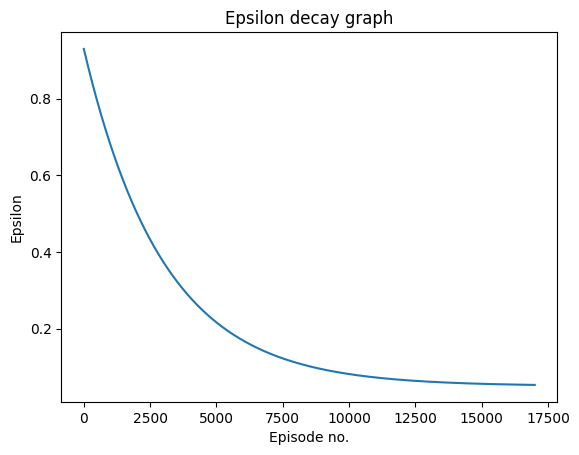

In [542]:

# epilson decay graph
EPS_START = 0.93
EPS_END = 0.05
EPS_DECAY = 3000

steps_done = np.arange(17000)
eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * steps_done / EPS_DECAY) # at the end, there is near 0 exploration

plt.plot(steps_done, eps)
plt.title('Epsilon decay graph')
plt.xlabel('Episode no.')
plt.ylabel('Epsilon')
plt.show()
plt.close()

In [543]:
import random

# memory block for deep q learning
# class replayMemory:
#     def __init__(self):
#         self.memory = []

#     def dump(self, transition_tuple):
#         self.memory.append(transition_tuple)

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)



from collections import deque
import random

class replayMemory:
    def __init__(self, capacity=100000):
        self.memory = deque(maxlen=capacity)

    def dump(self, transition_tuple):
        self.memory.append(transition_tuple)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


memory = replayMemory()

In [544]:
# minimax related stuff


class Player:
    def __init__(self):
        pass
    def play(self, state):
        pass


class MiniMaxPlayer(Player):
    def __init__(self):
        super().__init__()
        self.ROWS = 6
        self.COLS = 7
        self.CONNECT = 4
        self.WIN_REWARD = 10000
        self.BOTH_OPEN_THREE = 100
        self.SINGLE_OPEN_THREE = 20
        self.BOTH_OPEN_TWO = 40
        self.SINGLE_OPEN_TWO = 10
        self.CLOSED = 0
        self.not_sure = -3

   # Returns best score,best action for player
    def minimax(self, state, depth, player, maximizing_player):
        winner = self.check_winner(state)
        if winner == maximizing_player:
            return (np.iinfo(np.int32).max, None)
        elif winner == 1+(maximizing_player%2):
            return (np.iinfo(np.int64).min, None)
        elif self.is_draw(state):
              return (0, None)
        elif depth == 0:
            # print('reached 0 depth in ')
            # print('evaluation is', self.evaluate(state, player))
            # print(state)
            return (self.evaluate(state, player), None)
            # return (self.not_sure, random.choice(self.valid_moves(state)))

        if player == maximizing_player:
            max_eval = np.iinfo(np.int64).min
            best_actions = []
            for col in self.valid_moves(state):
                next_state = self.make_move(state, col, player)
                eval_score, _ = self.minimax(next_state, depth - 1, 1+(player%2), maximizing_player)
                if eval_score > max_eval:
                    max_eval = eval_score
                    best_actions = []
                    best_actions.append(col)
                elif eval_score == max_eval:
                    max_eval = eval_score
                    best_actions.append(col)
            if len(best_actions) == 0:
            #   print('random action by minimax, hopeless')
            #   print(state)
              best_action = random.choice(self.valid_moves(state))
              return (max_eval, best_action)
            elif len(best_actions) == 1:
            #   print('only the best', best_actions[0])
            #   print(state)
              return max_eval, best_actions[0]

            # print('random action by minimax no worries', best_actions)
            # print(state)

            return (max_eval, random.choice(best_actions)) # fix here should return a random action
        else:
            min_eval = np.iinfo(np.int32).max
            best_actions = []
            for col in self.valid_moves(state):
                next_state = self.make_move(state, col, player)
                eval_score, _ = self.minimax(next_state, depth - 1, 1+(player % 2), maximizing_player)
                if eval_score < min_eval:
                    min_eval = eval_score
                    best_actions = []
                    best_actions.append(col)
                elif eval_score == min_eval:
                    min_eval = eval_score
                    best_actions.append(col)
            if len(best_actions) == 0:
              best_action = random.choice(self.valid_moves(state))
            #   print('random action by minimax')
              return (min_eval, best_action)
            elif len(best_actions) == 1:
              return min_eval, best_actions[0]
            return (min_eval, random.choice(best_actions)) # fix here, returns a random action

    def valid_moves(self, state):
      state_2d = state.reshape(self.ROWS, self.COLS)  # Reshape to 2D
      return [c for c in range(self.COLS) if state_2d[0][c] == 0]  # Check top row

    def make_move(self, state, col, player):
        """Return new state after placing player's piece in the specified column."""
        new_state = state.copy().reshape(self.ROWS, self.COLS)  # Reshape to 2D
        for row in reversed(range(self.ROWS)):
            if new_state[row][col] == 0:
                new_state[row][col] = player
                break  # Fixed indentation
        return new_state

    def is_draw(self, state):
        """Check if the board is full (draw condition)."""
        state_2d = state.reshape(self.ROWS, self.COLS)
        return all(state_2d[0][c] != 0 for c in range(self.COLS))  # All top row occupied

    def check_winner(self, state):
        """Check if there's a winner (4 in a row horizontally, vertically, or diagonally)."""
        state_2d = state.reshape(self.ROWS, self.COLS)

        # Horizontal check
        for row in range(self.ROWS):
            for col in range(self.COLS - 3):
                if (state_2d[row][col] != 0 and
                    state_2d[row][col] == state_2d[row][col+1] ==
                    state_2d[row][col+2] == state_2d[row][col+3]):
                    return state_2d[row][col]

        # Vertical check
        for row in range(self.ROWS - 3):
            for col in range(self.COLS):
                if (state_2d[row][col] != 0 and
                    state_2d[row][col] == state_2d[row+1][col] ==
                    state_2d[row+2][col] == state_2d[row+3][col]):
                    return state_2d[row][col]

        # Diagonal (positive slope) check
        for row in range(self.ROWS - 3):
            for col in range(self.COLS - 3):
                if (state_2d[row][col] != 0 and
                    state_2d[row][col] == state_2d[row+1][col+1] ==
                    state_2d[row+2][col+2] == state_2d[row+3][col+3]):
                    return state_2d[row][col]

        # Diagonal (negative slope) check
        for row in range(3, self.ROWS):
            for col in range(self.COLS - 3):
                if (state_2d[row][col] != 0 and
                    state_2d[row][col] == state_2d[row-1][col+1] ==
                    state_2d[row-2][col+2] == state_2d[row-3][col+3]):
                    return state_2d[row][col]

        return None  # No winner found

    def evaluate(self, state, player):
        # simplify
        # opponent = 1 + (player%2)
        # if(self.check_winner(state) == player):
        #     return self.WIN_REWARD
        # elif (self.check_winner(state) == opponent):
        #     return -1*self.WIN_REWARD
        # else:
        #     return 0
        #simply end
        return self.score_position(state, player) - self.score_position(state, 1+(player % 2))

    def score_position(self, state, player):
        score = 0

        # Score center column
        center_array = [state[r][self.COLS // 2] for r in range(self.ROWS)]
        score += center_array.count(player) * 3

        # Score horizontal
        for row in range(self.ROWS):
            row_array = state[row]
            for col in range(self.COLS - 3):
                left = np.array([row_array[col-1] if col-1 >= 0 else (1+(player%2))])
                middle = row_array[col:col + self.CONNECT].flatten()
                right = np.array([row_array[col+self.CONNECT] if col+self.CONNECT < self.COLS else 1 + (player%2)])
                window = np.hstack([left, middle, right])
                score += self.evaluate_window(window, player)

        # Score vertical
        for col in range(self.COLS):
            col_array = np.array([state[r][col] for r in range(self.ROWS)])
            for row in range(self.ROWS - 3):
                left = np.array([col_array[row-1] if row-1 >= 0 else 1 + (player%2)])
                middle = col_array[row:row + self.CONNECT].flatten()
                right = np.array([col_array[row+self.CONNECT] if row+self.CONNECT < self.ROWS else 1 + (player%2)])
                window = np.hstack([left, middle, right])
                score += self.evaluate_window(window, player)

        # Score positive diagonal
        for row in range(self.ROWS - 3):
            for col in range(self.COLS - 3):
                left = np.array([state[row - 1][col - 1] if row - 1 >= 0 and col - 1 >= 0 else 1 + (player%2)])
                middle = np.array([state[row + i][col + i] for i in range(self.CONNECT)])
                right = np.array([state[row + self.CONNECT][col + self.CONNECT] if row + self.CONNECT < self.ROWS and col + self.CONNECT < self.COLS else 1 + (player%2)])
                window = np.hstack([left, middle, right])
                score += self.evaluate_window(window, player)

        # Score negative diagonal
        for row in range(3, self.ROWS):
            for col in range(self.COLS - 3):
                left = np.array([state[row + 1][col - 1] if row + 1 < self.ROWS and col - 1 >= 0 else 1 + (player%2)])
                middle = np.array([state[row - i][col + i] for i in range(self.CONNECT)])
                right = np.array([state[row - self.CONNECT][col + self.CONNECT] if row - self.CONNECT >= 0 and col + self.CONNECT < self.COLS else 1 + (player%2)])
                window = np.hstack([left, middle, right])
                score += self.evaluate_window(window, player)

        return score

    def evaluate_window(self, window6, player):
        try:
          assert(len(window6)==6)
        except:
          print(window6)
        opponent = 1 + (player%2)  # Toggle between player 1 and 2

        # Immediate block: opponent has 4 in a row
        if np.count_nonzero(window6 == opponent) == 4:
            return 0

        # Winning condition: player has 4 in a row in the middle of the window
        if np.count_nonzero(window6[1:5] == player) == 4:
            return self.WIN_REWARD


        # Detect open/closed three-in-a-row
        for i in range(1, 3):
            if window6[1 + i] == player and window6[2 + i] == player and window6[3 + i] == player:
                left = window6[i - 1]
                right = window6[i + 3]
                if left == 0 and right == 0:
                    return self.BOTH_OPEN_THREE
                elif left == opponent and right == opponent:
                    return self.CLOSED
                else:
                    return self.SINGLE_OPEN_THREE

        # Detect open/closed two-in-a-row
        for i in range(1, 4):
            if window6[1 + i] == player and window6[2 + i] == player:
                left = window6[i - 1]
                right = window6[i + 2]
                if left == 0 and right == 0:
                    return self.BOTH_OPEN_TWO
                elif left == opponent and right == opponent:
                    return self.CLOSED
                else:
                    return self.SINGLE_OPEN_TWO

        return self.CLOSED



In [545]:


class HeuristicPlayer():
    def __init__(self):
        self.board_width = 7
        self.board_height = 6
        pass

    def take_action(self, board, action, player):
        for r in range(self.board_height-1, -1, -1):
            if board[r][action] == 0:
                board[r][action] = player
                return board

    def undo_action(self, board, action, player):
        for r in range(0, self.board_height, 1):
            if board[r][action] == player:
                board[r][action] = 0
                return board

    def get_valid_moves(self, board):
        # returns the list of valid moves
        valid = []
        for c in range(0, self.board_width):
            if board[0][c] == 0:
                valid.append(c)
        return valid

    def check_game_done(self, board, player):
        # returns true if the game is over and player won
        if player == 1:
            check = '1 1 1 1'
        else:
            check = '2 2 2 2'

        # check vertically then horizontally
        for j in range(self.board_width):
            if check in np.array_str(board[:, j]):
                return True
        for i in range(self.board_height):
            if check in np.array_str(board[i, :]):
                return True

        # check left diagonal and right diagonal
        for k in range(0, self.board_height - 4 + 1):
            left_diagonal = np.array([board[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([board[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                return True
        for k in range(1, self.board_width - 4 + 1):
            left_diagonal = np.array([board[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([board[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                return True
        return False

    def check_win(self, board, player, action):
        # if doing action on board makes player win then return True
        # else return False
        temp_board = deepcopy(board)
        temp_board = self.take_action(temp_board, action, player)
        flag = self.check_game_done(temp_board, player)
        temp_board = self.undo_action(temp_board, action , player)
        return flag

    def form_double_trick(self, board, player, action):
        # if doing the action forms a double trick, return true o/w false

        #do the action
        temp_board = deepcopy(board)
        temp_board = self.take_action(temp_board, action, player)

        # now check if there are two different wins
        count = 0
        for a in self.get_valid_moves(temp_board):
            if self.check_win(temp_board, player, a):
                count += 1
        if count >= 2:
            return True
        else:
            return False

    def open3count(self, board, player, action):
        # return the number of open3s formed when player does action on board
        tempboard = deepcopy(board)
        tempboard = self.take_action(tempboard, action, player)
        bidirections = [[(0,1), (0,-1)], [(-1, 1), (1, -1)], [(-1,-1), (1,1)], [(-1,0), (1, 0)]]
        for i in range(0, self.board_height):
            if tempboard[i][action] == player:
                r = i
                break

        # so now at (r, action the move has been done)
        open3 = 0

        for bidirection in bidirections:
            # print('bidirection is', bidirection)
            count = 1
            # there are two ends per bidirection
            ends  = []
            for idx, direction in enumerate(bidirection):
                # print('direction is', direction)
                x,y = r,action
                x,y = x+direction[0],y+direction[1]
                while x < self.board_height and x >=0 and y < self.board_width and y >= 0:
                    # print('checking', x, y)
                    # print('it contains', tempboard[x][y])
                    if tempboard[x][y] == player:
                        count += 1
                    else:
                        if tempboard[x][y] == 0:
                            ends.append((x,y))
                        break
                    x,y = x+direction[0],y+direction[1]
                if count == 3:
                    open3 += len(ends)
            # print('count is', count)

        tempboard = self.undo_action(tempboard, action, player)
        return open3

    def open2count(self, board, player, action):
        # return the number of open2s formed when player does action on board
        tempboard = deepcopy(board)
        tempboard = self.take_action(tempboard, action, player)
        bidirections = [[(0,1), (0,-1)], [(-1, 1), (1, -1)], [(-1,-1), (1,1)], [(-1,0), (1, 0)]]
        for i in range(0, self.board_height):
            if tempboard[i][action] == player:
                r = i
                break

        # so now at (r, action the move has been done)
        open2 = 0

        for bidirection in bidirections:
            # print('bidirection is', bidirection)
            count = 1
            # there are two ends per bidirection
            ends  = []
            for idx, direction in enumerate(bidirection):
                # print('direction is', direction)
                x,y = r,action
                x,y = x+direction[0],y+direction[1]
                while x < self.board_height and x >=0 and y < self.board_width and y >= 0:
                    # print('checking', x, y)
                    # print('it contains', tempboard[x][y])
                    if tempboard[x][y] == player:
                        count += 1
                    else:
                        if tempboard[x][y] == 0:
                            ends.append((x,y))
                        break
                    x,y = x+direction[0],y+direction[1]
                if count == 2:
                    open2 += len(ends)
            # print('count is', count)

        tempboard = self.undo_action(tempboard, action, player)
        return open2

    def open1count(self, board, player, action):
        # return the number of open1s formed when player does action on board
        tempboard = deepcopy(board)
        tempboard = self.take_action(tempboard, action, player)
        bidirections = [[(0,1), (0,-1)], [(-1, 1), (1, -1)], [(-1,-1), (1,1)], [(-1,0), (1, 0)]]
        for i in range(0, self.board_height):
            if tempboard[i][action] == player:
                r = i
                break

        # so now at (r, action the move has been done)
        open1 = 0

        for bidirection in bidirections:
            # print('bidirection is', bidirection)
            count = 1
            # there are two ends per bidirection
            ends  = []
            for idx, direction in enumerate(bidirection):
                # print('direction is', direction)
                x,y = r,action
                x,y = x+direction[0],y+direction[1]
                while x < self.board_height and x >=0 and y < self.board_width and y >= 0:
                    # print('checking', x, y)
                    # print('it contains', tempboard[x][y])
                    if tempboard[x][y] == player:
                        count += 1
                    else:
                        if tempboard[x][y] == 0:
                            ends.append((x,y))
                        break
                    x,y = x+direction[0],y+direction[1]
                if count == 1:
                    open1 += len(ends)
            # print('count is', count)

        tempboard = self.undo_action(tempboard, action, player)
        return open1

    def get_bad_moves(self, board, player):
        # if opponent wins immidiately after your move, you suck
        opponent = 1 + (player%2)
        bad_moves = []
        for a in self.get_valid_moves(board):
            tempboard = deepcopy(board)
            self.take_action(tempboard, a, player)
            flag = False
            for b in self.get_valid_moves(tempboard):
                if self.check_win(tempboard, opponent, b):
                    flag = True
                    break
            self.undo_action(tempboard, a, player)
            if flag:
                bad_moves.append(a)
        return bad_moves

    def heuristic_player_move(self, board, player):
        """Heuristic player move logic."""
        opponent = 1 + (player%2)

        # if np.count_nonzero(board == 0) == 42:
        #     return 3 # the centre to start with

        # check if you yourself have a win
        for a in self.get_valid_moves(board):
            if self.check_win(board, player, a):
                # print('doing winning action')
                return a

        # block opponent's open wins
        for a in self.get_valid_moves(board):
            if self.check_win(board, opponent, a):
                # print('doing blocking action')
                return a

        bad_moves = self.get_bad_moves(board, player)
        # print(bad_moves)
        # if opponent wins after you play a move, that move is a bad move

        # block opponent's double tricks
        for a in self.get_valid_moves(board):
            if self.form_double_trick(board, opponent, a) and a not in bad_moves:
                # print('opp has double trick at ',a)
                return a


        # try to form double trick for yourself
        for a in self.get_valid_moves(board):
            if self.form_double_trick(board, player, a):
                if a not in bad_moves:
                    # print('double trick for me', a)
                    return a

        # if your move leads to a double trick for the opponent it's bad!!
        tempboard = deepcopy(board)
        for a in self.get_valid_moves(board):
            self.take_action(tempboard, a, player)
            for b in self.get_valid_moves(tempboard):
                if self.form_double_trick(tempboard, opponent, b):
                    bad_moves.append(a)
            self.undo_action(tempboard, a, player)

        # try to form multiple open 3s for yourself

        most3s_actions = []
        most3s = 0
        for a in self.get_valid_moves(board):
            # we need the number of open 3s it forms
            if self.open3count(board, player, a) > most3s:
                most3s_actions = [a]
                most3s = self.open3count(board, player, a)
            elif self.open3count(board, player, a) == most3s and most3s != 0:
                most3s_actions.append(a)

        most3s_actions = [a for a in most3s_actions if a not in bad_moves]

        if most3s > 1 and len(most3s_actions) > 0:
          # print('most3s action')
          return random.choice(most3s_actions)


        # try to form multiple open 2s for yourself

        most2s_actions = []
        most2s = 0
        for a in self.get_valid_moves(board):
            # we need the number of open 3s it forms
            if self.open2count(board, player, a) > most2s:
                most2s_actions = [a]
                most2s = self.open2count(board, player, a)
            elif self.open2count(board, player, a) == most2s and most2s != 0:
                most2s_actions.append(a)

        most2s_actions = [a for a in most2s_actions if a not in bad_moves]

        if most2s > most3s and len(most2s_actions) > 0:
          # print('most2s action')
          return random.choice(most2s_actions)
        elif len(most3s_actions) > 0:
          # print('most3s action')
          return random.choice(most3s_actions)

        # try to form open 1s for yourself
        # this means choose central cells on move 1...

        most1s_actions = []
        most1s = 0
        for a in self.get_valid_moves(board):
            # we need the number of open 3s it forms
            if self.open1count(board, player, a) > most1s:
                most1s_actions = [a]
                most1s = self.open1count(board, player, a)
            elif self.open1count(board, player, a) == most1s and most1s != 0:
                most1s_actions.append(a)

        # print('most1s_actions are', most1s_actions)
        for a in most1s_actions:
            if a not in bad_moves:
                # print('doing most 1s action')
                return a

        # avoid a bad move if possible
        good_moves = [a for a in self.get_valid_moves(board) if a not in bad_moves]
        if len(good_moves) > 0:
            # print('doing random good move')
            return random.choice(good_moves)


        # print('doing random action')
        return random.choice(self.get_valid_moves(board))


# x = np.array(
#     [
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#     ]
# )

# trick2test = np.array(
#     [
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 2, 0],
#         [0, 0, 0, 1, 1, 1, 0],
#         [0, 0, 1, 2, 1, 2, 0],
#         [0, 0, 2, 2, 2, 2, 0],
#     ]
# )

# x = np.array(
#     [
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 2, 0],
#         [0, 0, 0, 1, 1, 1, 0],
#         [2, 0, 1, 2, 1, 2, 0],
#         [2, 0, 2, 1, 2, 2, 0],
#     ]
# )


# open3test = np.array(
#     [
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 2, 0],
#         [0, 0, 0, 1, 1, 1, 0],
#         [0, 0, 1, 2, 1, 2, 0],
#         [0, 0, 2, 2, 2, 2, 0],
#     ]
# )

my_heur_player = HeuristicPlayer()


# # y = my_heur_player.take_action(x, 6, 1)
# # y = my_heur_player.undo_action(y, 6, 1)
# # print('a is ', y)

# # win = my_heur_player.check_win(x, 1, 4)
# # print('win is', win)


# # trick2 = my_heur_player.form_double_trick(trick2test, 1, 4)
# # print('trick2 is',  trick2)

# # open3 = my_heur_player.open3count(open3test, 1, 4)
# # print('open3 is', open3)

x = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
    ]
)

a = my_heur_player.heuristic_player_move(x,2)
print('a is ', a)

a is  5


In [546]:
# our model needs to learn not to miss wins and it must also learn to block when someone else is about to win
# shape rewards such that this objective is taken care of

# we can use the heuristic player to see if the opponent has a win or not and accordingly reward our foolish agent
import numpy as np
from copy import deepcopy
import random


class WinBlockPlayer():
    def __init__(self):
        self.board_width = 7
        self.board_height = 6
        pass

    def take_action(self, board, action, player):
        for r in range(self.board_height-1, -1, -1):
            if board[r][action] == 0:
                board[r][action] = player
                return board

    def undo_action(self, board, action, player):
        for r in range(0, self.board_height, 1):
            if board[r][action] == player:
                board[r][action] = 0
                return board

    def get_valid_moves(self, board):
        # returns the list of valid moves
        valid = []
        for c in range(0, self.board_width):
            if board[0][c] == 0:
                valid.append(c)
        return valid

    def check_game_done(self, board, player):
        # returns true if the game is over and player won
        if player == 1:
            check = '1 1 1 1'
        else:
            check = '2 2 2 2'

        # check vertically then horizontally
        for j in range(self.board_width):
            if check in np.array_str(board[:, j]):
                return True
        for i in range(self.board_height):
            if check in np.array_str(board[i, :]):
                return True

        # check left diagonal and right diagonal
        for k in range(0, self.board_height - 4 + 1):
            left_diagonal = np.array([board[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([board[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                return True
        for k in range(1, self.board_width - 4 + 1):
            left_diagonal = np.array([board[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([board[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in np.array_str(left_diagonal) or check in np.array_str(right_diagonal):
                return True
        return False

    def check_win(self, board, player, action):
        # if doing action on board makes player win then return True
        # else return False
        temp_board = deepcopy(board)
        temp_board = self.take_action(temp_board, action, player)
        flag = self.check_game_done(temp_board, player)
        temp_board = self.undo_action(temp_board, action , player)
        return flag

    def get_bad_moves(self, board, player):
        # if opponent wins immidiately after your move, you suck
        opponent = 1 + (player%2)
        bad_moves = []
        for a in self.get_valid_moves(board):
            tempboard = deepcopy(board)
            self.take_action(tempboard, a, player)
            flag = False
            for b in self.get_valid_moves(tempboard):
                if self.check_win(tempboard, opponent, b):
                    flag = True
                    break
            self.undo_action(tempboard, a, player)
            if flag:
                bad_moves.append(a)
        return bad_moves

    def wb_player_move(self, board, player):
        opponent  = 1 + (player%2)
        # if we have a win, win
        # if they have a win, block
        # otherwise random

        # print("board:", board)
        # print("player:", player)

        winning_action_for_me = None
        tempboard = deepcopy(board)
        for a in self.get_valid_moves(tempboard):
            # print("a:", a)

            if self.check_win(tempboard, player, a):
                winning_action_for_me = a
                break
        if winning_action_for_me is not None:
            # print("a in first loop:", a)
            return a

        winning_action_for_them  = None
        for a in self.get_valid_moves(tempboard):
            # print("a second:", a)
            
            if self.check_win(tempboard, opponent, a):
                winning_action_for_them = a
                break
        if winning_action_for_them is not None:
            # print("a in second loop:", a)
            return a
        
        # try:
        # print("before")
        a = self.get_valid_moves(tempboard)
        # print("after")
        # print("a:", a)
        if a != []:
            a = random.choice(a)
            # except:
            #     a = None

            # print("random a:", a)
            return a
        else:
            return None

In [547]:

# mcts adapted to this current environment



# hyper params
class GameMeta:
    PLAYERS = {'none': 0, 'one': 1, 'two': 2}
    OUTCOMES = {'none': 0, 'one': 1, 'two': 2, 'draw': 3}
    INF = float('inf')
    ROWS = 6
    COLS = 7


class MCTSMeta:
    EXPLORATION = math.sqrt(2)



class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0
        self.Q = 0
        self.children = {}
        self.outcome = GameMeta.PLAYERS['none']

    def add_children(self, children: dict) -> None:
        for child in children:
            self.children[child.move] = child

    def value(self, explore: float = MCTSMeta.EXPLORATION):
        if self.N == 0:
            return 0 if explore == 0 else GameMeta.INF
        else:
            return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)


class MCTS:
    def __init__(self, state=connect_4()):
        self.root_state = deepcopy(state)
        self.root = Node(None, None)
        self.run_time = 0
        self.node_count = 0
        self.num_rollouts = 0

    def select_node(self) -> tuple:
        node = self.root
        state = deepcopy(self.root_state)
        player = None
        if np.count_nonzero(state.board_state == 0)%2 == 0:
            player = 'p1'
        else:
            player = 'p2'
        while len(node.children) != 0:
            children = node.children.values()
            max_value = max(children, key=lambda n: n.value()).value()
            max_nodes = [n for n in children if n.value() == max_value]

            node = random.choice(max_nodes)
            state.make_move(node.move, player)

            if node.N == 0:
                return node, state

        if self.expand(node, state):
            node = random.choice(list(node.children.values()))
            state.make_move(node.move, player)

        return node, state

    def expand(self, parent: Node, state: connect_4) -> bool:
        state.check_game_done('p1')
        state.check_game_done('p2')
        if state.isDone:
            return False

        children = [Node(move, parent) for move in state.get_available_actions()]
        parent.add_children(children)

        return True

    def roll_out(self, state: connect_4) -> int:
        while not state.isDone:
            player = None
            if np.count_nonzero(self.root_state.board_state == 0)%2 == 0:
                player = 'p1'
            else:
                player = 'p2'
            state.make_move(random.choice(state.get_available_actions()), player)
            state.check_game_done('p1')
            state.check_game_done('p2')

        # return state.get_outcome()
        # return draw win or loss or nothing based on the situtation
        r1 = state.check_game_done('p1')
        r2 = state.check_game_done('p2')

        if r1 == state.reward['win']:
            return GameMeta.OUTCOMES['one']
        elif r2 == state.reward['win']:
            return GameMeta.OUTCOMES['two']
        elif r1 == state.reward['draw']:
            return GameMeta.OUTCOMES['draw']
        elif r2 == state.reward['draw']:
            return GameMeta.OUTCOMES['draw']
        else:
            return 0

    def back_propagate(self, node: Node, turn: int, outcome: int) -> None:

        # For the current player, not the next player
        reward = 0 if outcome == turn else 1

        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            if outcome == GameMeta.OUTCOMES['draw']:
                reward = 0
            else:
                reward = 1 - reward

    def search(self, time_limit: int):
        start_time = time.process_time()

        num_rollouts = 0
        while time.process_time() - start_time < time_limit:
            node, state = self.select_node()
            outcome = self.roll_out(state)
            self.back_propagate(node, state.turn, outcome)
            num_rollouts += 1

        run_time = time.process_time() - start_time
        self.run_time = run_time
        self.num_rollouts = num_rollouts

    def best_move(self):
        if self.root_state.isDone:
            return -1

        max_value = max(self.root.children.values(), key=lambda n: n.N).N
        max_nodes = [n for n in self.root.children.values() if n.N == max_value]
        best_child = random.choice(max_nodes)

        return best_child.move

    def move(self, move):
        player = None
        if np.count_nonzero(self.root_state.board_state == 0)%2 == 0:
            player = 'p1'
        else:
            player = 'p2'
        if move in self.root.children:
            self.root_state.make_move(move, player)
            self.root = self.root.children[move]
            return

        self.root_state.make_move(move, player)
        self.root = Node(None, None)

    def statistics(self) -> tuple:
        return self.num_rollouts, self.run_time



In [548]:
# from google.colab import drive
# drive.mount('/content/drive')


In [552]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps') if torch.backends.mps.is_available() and torch.backends.mps.is_built() else device

# import os
print(device)
# os.listdir('/content/drive/MyDrive')

cpu


In [555]:
# choice opponent
# explore how different learning rates work...
# 1e3 is not so bad
file_to_load = '/Users/soardr/RL Project 6th sem/models/DQN_minimaxd2.pth'
file_to_save = '/Users/soardr/RL Project 6th sem/models/DQN_wb__reward_2__quantum.pth'
steps_done = 0

EPS_DECAY = 3000



depth = 2
env = connect_4()
BATCH_SIZE = 128
GAMMA = 0.999
memory = replayMemory()
# get max no. of actions from action space
n_actions = env.board_width

height = env.board_height
width = env.board_width


policy_net = QuantumDQN(n_actions).to(device)
# policy_net = DQN(n_actions).to(device)

# policy_net.load_state_dict(torch.load(file_to_load, weights_only=True, map_location=device))
# policy_net.load_state_dict(torch.load('/content/drive/MyDrive/DQN_curriculum.pth', weights_only=True, map_location=device))
# policy_net.load_state_dict(torch.load("./models/DQN_minimax_d2.pth", weights_only=True))

# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence

target_net = QuantumDQN(n_actions).to(device)
# target_net = DQN(n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

lr = 5e-4
optimizer = optim.Adam(policy_net.parameters(), lr=lr) # v fast !?


def select_action(state, available_actions, steps_done=None, training=True):
    # batch and color channel
    if len(available_actions) == 0:
        print('no actions available so we will return')
        return None
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0

    # follow epsilon-greedy policy
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net
            # print("state:", state.shape)
            
            r_actions = policy_net(state)
            # r_actions = torch.unsqueeze(r_actions, dim=0)
            # print(r_actions.shape)

            r_actions = r_actions[0, :]

            state_action_values = [r_actions[action].item() for action in available_actions]
            argmax_action = np.argmax(state_action_values).item()
            greedy_action = available_actions[argmax_action]
            return greedy_action
    else:
        return random.choice(available_actions)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
                                        [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])

    if state_batch is None or action_batch is None or reward_batch is None:
        return
    # tensor wrapper
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    action_batch = torch.tensor(action_batch, dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)

    # for assigning terminal state value = 0 later
    non_final_mask = torch.tensor(tuple(map(lambda s_: s_[0] is not None, next_state_batch)), device=device)
    non_final_next_state = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in next_state_batch if s_[0] is not None])

    # prediction from policy_net
    state_action_values_temp = policy_net(state_batch)
    # state_action_values_temp = torch.unsqueeze(state_action_values_temp, dim=0)
    # print("state_action_values_temp main code:", state_action_values_temp.shape)
    # print("action_batch:", action_batch.shape)

    state_action_values = state_action_values_temp.gather(1, action_batch)

    # truth from target_net, initialize with zeros since terminal state value = 0
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1)[0].detach()
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)) # torch.tensor.unsqueeze returns a copy

    optimizer.zero_grad()
    loss.backward()

    # this is very large!!!!, I need to be careful...
    # total_norm = 0
    # for p in policy_net.parameters():
    #     if p.grad is not None:
    #         param_norm = p.grad.data.norm(2)
    #         total_norm += param_norm.item() ** 2
    # total_norm = total_norm ** 0.5
    # print(f"Gradient norm: {total_norm}")

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
    optimizer.step()

my_minimax_player = MiniMaxPlayer()
my_wb_player = WinBlockPlayer()


# random agent
def random_agent(actions):
    return random.choice(actions)


num_episodes = 15040
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 100

# avoid resetting
steps_done = 0
win_rates = [] # draw === loss

wins = 0
losses = 0




for i in range(num_episodes):
    steps_done += 1
    # if i % 500 == 0:
    if True:
      print('episode ', i)
      if(len(win_rates) > 0):
        print(f'recent win rate is {win_rates[-1]}')

    if (i+1)%1000 == 0:
      path = file_to_save
      torch.save(policy_net.state_dict(), path)
    env.reset()
    state_p1 = env.board_state.copy()

    if i % 100 == 99:
      win_rates.append(wins / (wins + losses))
      wins = 0
      losses = 0

    for t in count():
        available_actions = env.get_available_actions()
        action_p1 = select_action(state_p1, available_actions, steps_done)
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        # env.check_game_done('p1')

        if env.isDone:
            if reward_p1 == env.reward['win']:
                # reward p1 for p1's win
                memory.dump([state_p1, action_p1, env.reward['win'], None])
                wins += 1
            else:
                # state action value tuple for a draw
                print('should never get here')
                memory.dump([state_p1, action_p1, 5, None])
                losses += 1
            break
        # elif env.valid_3:
        #     if reward_p1 == env.reward['valid_3']:
        #         # punish p1 for (random agent) p2's win
        #         memory.dump([state_p1, action_p1, env.reward['valid_3'], None])
        #         losses += 1
        #     else:
        #         # state action value tuple for a draw
        #         print('should never get here valid 3:', reward_p1)
        #         memory.dump([state_p1, action_p1, 5, None])
        #         losses += 1
        #     # break
        # elif env.valid_2:
        #     if reward_p1 == env.reward['valid_2']:
        #         # punish p1 for (random agent) p2's win
        #         memory.dump([state_p1, action_p1, env.reward['valid_2'], None])
        #         losses += 1
        #     else:
        #         # state action value tuple for a draw
        #         print('should never get here valid 2:', reward_p1)
        #         memory.dump([state_p1, action_p1, 5, None])
        #         losses += 1
            # break

        available_actions = env.get_available_actions()
        # action_p2 = opponent1(state_p1_)
        # action_p2  = random.choice(available_actions)
        # score, action_p2 = my_minimax_player.minimax(state_p1_, depth, 2, 2)

        # print("state_p1_:", state_p1_)
        action_p2 = my_wb_player.wb_player_move(state_p1_, 2)

        # if action_p2 is not None:
        if True:
            state_p2_, reward_p2 = env.make_move(action_p2, 'p2')

            # env.check_game_done('p2') # already called in make_move
            if env.isDone:
                if reward_p2 == env.reward['win']:
                    # punish p1 for (random agent) p2's win
                    memory.dump([state_p1, action_p1, env.reward['lose'], None])
                    losses += 1
                else:
                    # state action value tuple for a draw
                    print('draw => break')
                    memory.dump([state_p1, action_p1, env.reward['draw'], None])
                    losses += 1
                break
            # elif env.valid_3:
            #     if reward_p2 == env.reward['valid_3']:
            #         # punish p1 for (random agent) p2's win
            #         memory.dump([state_p1, action_p1, env.reward['valid_3'], None])
            #         losses += 1
            #     else:
            #         # state action value tuple for a draw
            #         print('draw => break')
            #         memory.dump([state_p1, action_p1, env.reward['draw'], None])
            #         losses += 1
            #     # break
            # elif env.valid_2:
            #     if reward_p2 == env.reward['valid_2']:
            #         # punish p1 for (random agent) p2's win
            #         memory.dump([state_p1, action_p1, env.reward['valid_2'], None])
            #         losses += 1
            #     else:
            #         # state action value tuple for a draw
            #         print('draw => break')
            #         memory.dump([state_p1, action_p1, env.reward['draw'], None])
            #         losses += 1
                # break

            # punish for taking too long to win
            memory.dump([state_p1, action_p1, -0.05, state_p2_])
            state_p1 = state_p2_

            # Perform one step of the optimization (on the policy network)
            optimize_model()

    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1: # hard update, we could do a soft one here
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

# Plotting the win rates
plt.figure(figsize=(10, 5))
plt.plot(range(len(win_rates)), win_rates, label='Win Rate')
plt.xlabel('Checkpoint (every 100 episodes)')
plt.ylabel('Win Rate')
plt.title('Agent Win Rate Over Time')
plt.grid(True)
plt.legend()
plt.show()



path = file_to_save
torch.save(policy_net.state_dict(), path)


print("----------------------------------------------------------")
print('target update', TARGET_UPDATE)
print('learning rate', lr)
print('num episodes', num_episodes)
print('epsilon decay', EPS_DECAY)
print("----------------------------------------------------------")

episode  0
episode  1
episode  2
episode  3
episode  4
episode  5
episode  6
episode  7
episode  8
episode  9
episode  10
episode  11
episode  12
episode  13
episode  14
episode  15
episode  16
episode  17
episode  18
episode  19
episode  20
episode  21
episode  22
episode  23
episode  24
episode  25
episode  26
episode  27
episode  28
episode  29
episode  30
episode  31
episode  32
episode  33
episode  34
episode  35
episode  36
episode  37
episode  38
episode  39
episode  40
episode  41
episode  42
episode  43
episode  44
episode  45
episode  46
episode  47
episode  48
episode  49
episode  50
episode  51
episode  52
episode  53
episode  54
episode  55
episode  56
episode  57
episode  58
episode  59
episode  60
episode  61
episode  62
episode  63
episode  64
episode  65
episode  66
episode  67
episode  68
episode  69
episode  70
episode  71
episode  72
episode  73
episode  74
episode  75
episode  76
episode  77
episode  78
episode  79
episode  80
episode  81
episode  82
episode  83
ep

KeyboardInterrupt: 

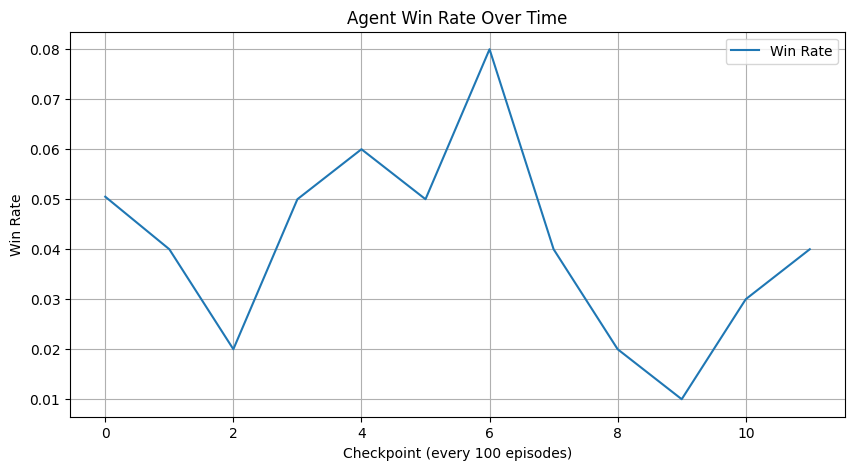

----------------------------------------------------------
target update 100
learning rate 0.0005
num episodes 15040
epsilon decay 3000
----------------------------------------------------------


In [557]:
# win_rates = [0.05, 0.07, 0.09, 0.12, 0.   03, 0.05, 0.07, 0.05, 0.09, 0.07, 0.05, 0.03, 0.09, 0.05, 0.07, 0.09]

# win_rates = []
# for i in range(100):
#     win_rates.append(0.050505050505050504)
# for i in range(100):
#     win_rates.append(0.04)
# for i in range(100):
#     win_rates.append(0.02)
# for i in range(100):
#     win_rates.append(0.05)
# for i in range(100):
#     win_rates.append(0.06)
# for i in range(100):
#     win_rates.append(0.05)
# for i in range(100):
#     win_rates.append(0.08)
# for i in range(100):
#     win_rates.append(0.04)
# for i in range(100):
#     win_rates.append(0.02)
# for i in range(100):
#     win_rates.append(0.01)
# for i in range(100):
#     win_rates.append(0.03)
# for i in range(100):
#     win_rates.append(0.04)

win_rates = [0.050505050505050504, 0.04, 0.02, 0.05, 0.06, 0.05, 0.08, 0.04, 0.02, 0.01, 0.03, 0.04]

# Plotting the win rates
plt.figure(figsize=(10, 5))
plt.plot(range(len(win_rates)), win_rates, label='Win Rate')
plt.xlabel('Checkpoint (every 100 episodes)')
plt.ylabel('Win Rate')
plt.title('Agent Win Rate Over Time')
plt.grid(True)
plt.legend()
plt.show()



path = file_to_save
torch.save(policy_net.state_dict(), path)


print("----------------------------------------------------------")
print('target update', TARGET_UPDATE)
print('learning rate', lr)
print('num episodes', num_episodes)
print('epsilon decay', EPS_DECAY)
print("----------------------------------------------------------")

episode  0
Complete


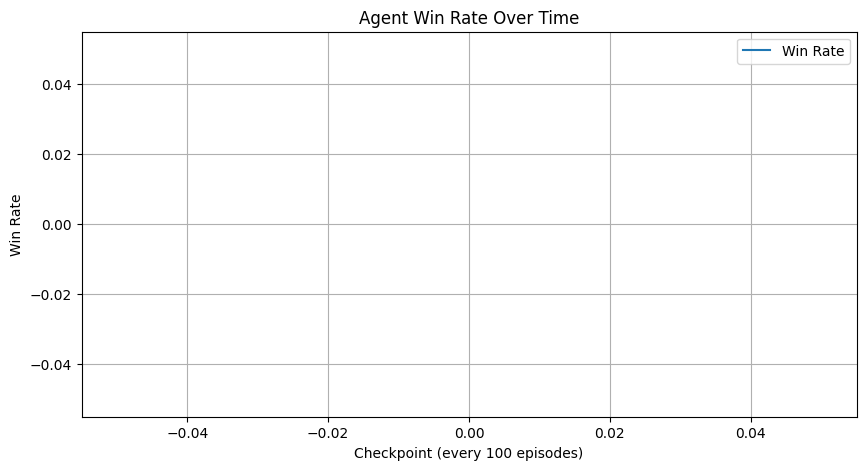

In [ ]:
# curriculum learning
# increasing the learning rate
# gradient clipping?

steps_done = 0


# 1	Random	2000	Learn basic moves, avoid random losses
# 2	Minimax (depth=1)	1000	Learn to respond to shallow threats
# 3	Minimax (depth=2)	3000	Understand multi-step traps
# 4	Heuristic Rule-Based	9000	Compete with strategic play, refine tactics
# total 15000 eps

EPS_DECAY = 3000
depth = 1

def get_curriculum_opponent(episode):
    global steps_done
    global depth
    if episode < 2000:
        return lambda state: random_agent(env.get_available_actions())
    elif episode == 2000:
        steps_done = 0
        EPS_DECAY = 2000
        minimax1 = MiniMaxPlayer()
        return lambda state: minimax1.minimax(state, depth, 2, 2)[1]
    elif episode < 3000:
        minimax1 = MiniMaxPlayer()
        return lambda state: minimax1.minimax(state, depth, 2, 2)[1]
    elif episode == 3000:
        steps_done = 0
        EPS_DECAY = 6000
        depth = 2
        minimax2 = MiniMaxPlayer()
        return lambda state: minimax2.minimax(state, depth, 2, 2)[1]
    elif episode < 6000:
        minimax2 = MiniMaxPlayer()
        return lambda state: minimax2.minimax(state, depth, 2, 2)[1]
    elif episode == 6000:
        steps_done = 0
        EPS_DECAY = 18000
        heuristic = HeuristicPlayer()
        return lambda state: heuristic.heuristic_player_move(state, player=2)
    else:
        heuristic = HeuristicPlayer()
        return lambda state: heuristic.heuristic_player_move(state, player=2)



# Assuming that we are on a CUDA machine, this should print a CUDA device:
# print(device)
env = connect_4()
BATCH_SIZE = 256
GAMMA = 0.999
memory = replayMemory()
# get max no. of actions from action space
n_actions = env.board_width

height = env.board_height
width = env.board_width

policy_net = DQN(n_actions).to(device)
# policy_net.load_state_dict(torch.load('/content/drive/MyDrive/DQN_curriculum.pth', weights_only=True, map_location=device))
# policy_net.load_state_dict(torch.load("./models/DQN_minimax_d2.pth", weights_only=True))

# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

# optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

def select_action(state, available_actions, steps_done=None, training=True):
    # batch and color channel
    if len(available_actions) == 0:
        print('no actions available so we will return')
        return None
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0

    # follow epsilon-greedy policy
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net
            r_actions = policy_net(state)[0, :]
            state_action_values = [r_actions[action].item() for action in available_actions]
            argmax_action = np.argmax(state_action_values).item()
            greedy_action = available_actions[argmax_action]
            return greedy_action
    else:
        return random.choice(available_actions)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
                                        [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])

    if state_batch is None or action_batch is None or reward_batch is None:
        return
    # tensor wrapper
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    action_batch = torch.tensor(action_batch, dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)

    # for assigning terminal state value = 0 later
    non_final_mask = torch.tensor(tuple(map(lambda s_: s_[0] is not None, next_state_batch)), device=device)
    non_final_next_state = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in next_state_batch if s_[0] is not None])

    # prediction from policy_net
    state_action_values_temp = policy_net(state_batch)
    print("state_action_values_temp:", state_action_values_temp)

    state_action_values = state_action_values_temp.gather(1, action_batch)

    # truth from target_net, initialize with zeros since terminal state value = 0
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1)[0].detach()
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)) # torch.tensor.unsqueeze returns a copy

    optimizer.zero_grad()
    loss.backward()

    # this is very large!!!!, I need to be careful...
    # total_norm = 0
    # for p in policy_net.parameters():
    #     if p.grad is not None:
    #         param_norm = p.grad.data.norm(2)
    #         total_norm += param_norm.item() ** 2
    # total_norm = total_norm ** 0.5
    # print(f"Gradient norm: {total_norm}")

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 5)
    optimizer.step()


# random agent
def random_agent(actions):
    return random.choice(actions)


num_episodes = 10
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 20

# avoid resetting
steps_done = 0
win_rates = [] # draw === loss

wins = 0
losses = 0


for i in range(num_episodes):
    if i % 500 == 0:
      print('episode ', i)
      if(len(win_rates) > 0):
        print(f'recent win rate is {win_rates[-1]}')

    if i%1000 == 0:
      path = '/Users/soardr/RL Project 6th sem/models/DQN_curriculum.pth'
      torch.save(policy_net.state_dict(), path)
    env.reset()
    state_p1 = env.board_state.copy()

    if i % 100 == 99:
      win_rates.append(wins / (wins + losses))
      wins = 0
      losses = 0

    steps_done += 1
    for t in count():
        available_actions = env.get_available_actions()
        action_p1 = select_action(state_p1, available_actions, steps_done)

        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        # env.check_game_done('p1')

        if env.isDone:
            if reward_p1 == env.reward['win']:
                # reward p1 for p1's win
                memory.dump([state_p1, action_p1, 1000, None])
                wins += 1
            else:
                # state action value tuple for a draw
                print('should never get here')
                memory.dump([state_p1, action_p1, 5, None])
                losses += 1
            break

        available_actions = env.get_available_actions()
        opponent1 = get_curriculum_opponent(i)  # `i` is the current episode
        action_p2 = opponent1(state_p1_)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')

        # env.check_game_done('p2') # already called in make_move
        if env.isDone:
            if reward_p2 == env.reward['win']:
                # punish p1 for (random agent) p2's win
                memory.dump([state_p1, action_p1, -1000, None])
                losses += 1
            else:
                # state action value tuple for a draw
                print('draw => break')
                memory.dump([state_p1, action_p1, 0.5, None])
                losses += 1
            break

        # punish for taking too long to win
        memory.dump([state_p1, action_p1, -0.05, state_p2_])
        state_p1 = state_p2_

        # Perform one step of the optimization (on the policy network)
        optimize_model()

    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1: # hard update, we could do a soft one here
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

# Plotting the win rates
plt.figure(figsize=(10, 5))
plt.plot(range(len(win_rates)), win_rates, label='Win Rate')
plt.xlabel('Checkpoint (every 100 episodes)')
plt.ylabel('Win Rate')
plt.title('Agent Win Rate Over Time')
plt.grid(True)
plt.legend()
plt.show()



path = '/Users/soardr/RL Project 6th sem/models/DQN_curriculum.pth'
torch.save(policy_net.state_dict(), path)

In [434]:
# fast learning rate
# decay after episode only
steps_done = 0


EPS_DECAY = 3000
depth = 1


my_heur_player = HeuristicPlayer()

# Assuming that we are on a CUDA machine, this should print a CUDA device:
# print(device)
env = connect_4()
BATCH_SIZE = 256
GAMMA = 0.999
memory = replayMemory()
# get max no. of actions from action space
n_actions = env.board_width

height = env.board_height
width = env.board_width

policy_net = DQN(n_actions).to(device)
policy_net.load_state_dict(torch.load('/Users/soardr/RL Project 6th sem/models/DQN_curriculum.pth', weights_only=True, map_location=device))
# policy_net.load_state_dict(torch.load("./models/DQN_minimax_d2.pth", weights_only=True))

# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

# optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

def select_action(state, available_actions, steps_done=None, training=True):
    # batch and color channel
    if len(available_actions) == 0:
        print('no actions available so we will return')
        return None
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0

    # follow epsilon-greedy policy
    r_actions = policy_net(state)[0, :]
    state_action_values = [r_actions[action].item() for action in available_actions]
    # print('here are the vals')
    # print(state_action_values)
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net
            r_actions = policy_net(state)[0, :]
            state_action_values = [r_actions[action].item() for action in available_actions]
            argmax_action = np.argmax(state_action_values).item()
            greedy_action = available_actions[argmax_action]
            # print('doing greedy action')
            return greedy_action
    else:
        # print('doing random action')
        return random.choice(available_actions)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
                                        [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])

    if state_batch is None or action_batch is None or reward_batch is None:
        return
    # tensor wrapper
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    action_batch = torch.tensor(action_batch, dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)

    # for assigning terminal state value = 0 later
    non_final_mask = torch.tensor(tuple(map(lambda s_: s_[0] is not None, next_state_batch)), device=device)
    non_final_next_state = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in next_state_batch if s_[0] is not None])

    # prediction from policy_net
    state_action_values_temp = policy_net(state_batch)
    print("state_action_values_temp:", state_action_values_temp.shape)

    state_action_values = state_action_values_temp.gather(1, action_batch)

    # truth from target_net, initialize with zeros since terminal state value = 0
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1)[0].detach()
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)) # torch.tensor.unsqueeze returns a copy

    optimizer.zero_grad()
    loss.backward()

    # this is very large!!!!, I need to be careful...
    # total_norm = 0
    # for p in policy_net.parameters():
    #     if p.grad is not None:
    #         param_norm = p.grad.data.norm(2)
    #         total_norm += param_norm.item() ** 2
    # total_norm = total_norm ** 0.5
    # print(f"Gradient norm: {total_norm}")

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 5)
    optimizer.step()


# random agent
def random_agent(actions):
    return random.choice(actions)


num_episodes = 21500
EPS_DECAY = 3000
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 10

# avoid resetting
steps_done = 0
win_rates = [] # draw === loss
eps_values = []

wins = 0
losses = 0


for i in range(num_episodes):
    if i % 500 == 0:
      print('episode ', i)
      if(len(win_rates) > 0):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
        print('epsilon is ', eps_threshold)
        print(f'recent win rate is {win_rates[-1]}')

    if i%1000 == 0:
      path = '/Users/soardr/RL Project 6th sem/models/DQN_curriculum.pth'
      torch.save(policy_net.state_dict(), path)
    env.reset()
    state_p1 = env.board_state.copy()

    if i % 100 == 99:
      win_rates.append(wins / (wins + losses))
      eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
      eps_values.append(eps_threshold)
      wins = 0
      losses = 0

    steps_done += 1
    for t in count():
        # env.render()
        available_actions = env.get_available_actions()
        action_p1 = select_action(state_p1, available_actions, steps_done)
        # print('select action chose', action_p1)
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        # env.check_game_done('p1')

        if env.isDone:
            if reward_p1 == env.reward['win']:
                # reward p1 for p1's win
                memory.dump([state_p1, action_p1, 1000, None])
                wins += 1
            else:
                # state action value tuple for a draw
                print('should never get here')
                memory.dump([state_p1, action_p1, 5, None])
                losses += 1
            break

        available_actions = env.get_available_actions()
        # opponent1 = get_curriculum_opponent(i)  # `i` is the current episode
        # action_p2 = opponent1(state_p1_)

        # env.render()
        # action_p2 = int(input())
        action_p2 = my_heur_player.heuristic_player_move(env.get_board(), 2)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')

        # env.check_game_done('p2') # already called in make_move
        if env.isDone:
            if reward_p2 == env.reward['win']:
                # punish p1 for (random agent) p2's win
                memory.dump([state_p1, action_p1, -1000, None])
                losses += 1
            else:
                # state action value tuple for a draw
                print('draw => break')
                memory.dump([state_p1, action_p1, 0.5, None])
                losses += 1
            break

        # punish for taking too long to win
        memory.dump([state_p1, action_p1, -0.05, state_p2_])
        state_p1 = state_p2_

        # Perform one step of the optimization (on the policy network)
        optimize_model()

    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1: # hard update, we could do a soft one here
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

# Plotting the win rates
plt.figure(figsize=(10, 5))
plt.plot(range(len(win_rates)), win_rates, label='Win Rate')
plt.xlabel('Checkpoint (every 100 episodes)')
plt.ylabel('Win Rate')
plt.title('Agent Win Rate Over Time')
plt.grid(True)
plt.legend()
plt.show()



path = '/Users/soardr/RL Project 6th sem/models/DQN_curriculum.pth'
torch.save(policy_net.state_dict(), path)

episode  0
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
state_action_values_temp: torch.Size([256, 7])
st

KeyboardInterrupt: 

In [ ]:
# test loaded
policy_net = DQN(7).to(device)
load1 = '/Users/soardr/RL Project 6th sem/models/DQN_minimaxd2.pth'
policy_net.load_state_dict(torch.load(load1, weights_only=True, map_location=device))


x = np.array(
    [[0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 0, 0],
    [0, 0, 1, 1, 1, 2, 0],
    ]
)

my_minimax_player = MiniMaxPlayer()
my_heur_player = HeuristicPlayer()


def select_action(state, available_actions, steps_done=None, training=True, net=policy_net):
    # batch and color channel
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0

    # follow epsilon-greedy policy
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net

            r_actions = policy_net(state)[0, :]
            state_action_values = [r_actions[action].item() for action in available_actions]
            argmax_action = np.argmax(state_action_values).item()
            greedy_action = available_actions[argmax_action]

            # Continue with the rest of the code

            return greedy_action
    else:
        return random.choice(available_actions)

env = connect_4()
env.reset()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_episodes = 1
wins=0
losses = 0

search_time = 8
mcts = MCTS()


for episode in range(num_episodes):
    env.reset()
    while not env.isDone:

        # print('agent moved')
        state = env.get_board()
        with torch.no_grad():
            # a1 = select_action(state, env.get_available_actions(), 0, False)

            print('q values are ')
            state_tensor = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
            print(policy_net(state_tensor))
            # a1 = my_heur_player.heuristic_player_move(state, 1)
        state_p1_, reward_p1 = env.make_move(a1, 'p1')
        env.render()

        # env.check_game_done('p1')
        if env.isDone:
            wins += 1
            break

        # print('player moved')

        state = env.get_board()
        # a2 = random.choice(env.get_available_actions())
        # a2= my_heur_player.heuristic_player_move(state, 2)
        score, a2 = my_minimax_player.minimax(state, 2, 2, 2)
        # print('a2 is', a2)
        # print('score is ', score)
        # if score != np.iinfo(np.int32).max and score != np.iinfo(np.int32).min:
        #   a2 = random.choice(env.get_available_actions())
        # input()
        state_p2_, reward_p2 = env.make_move(a2, 'p2')
        env.render()

        # env.check_game_done('p2')

        if env.isDone:
            losses += 1
print('win rate is', wins/(wins+losses))



#  	0 	1 	2 	3 	4 	5 	6
# 0
# 1 		O
# 2 		X 	X
# 3 	X 	X 	O
# 4 	X 	X 	O 	O
# 5 	O 	O 	O 	X


q values are 
tensor([[-10.0645, -10.0214, -10.0798,  -9.9936, -10.1166, -10.0779, -10.0612]])


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,,O,,,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,,O,X,,


q values are 
tensor([[ -9.9892,  -9.9466, -10.0050,  -9.9198, -10.0415, -10.0024,  -9.9865]])


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,O,,,
5,,,,O,X,,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,O,,,
5,,,,O,X,X,


q values are 
tensor([[-9.9268, -9.8843, -9.9428, -9.8590, -9.9791, -9.9392, -9.9252]])


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,O,,,
4,,,,O,,,
5,,,,O,X,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,X,,,
3,,,,O,,,
4,,,,O,,,
5,,,,O,X,X,


q values are 
tensor([[-9.8674, -9.8237, -9.8823, -9.8018, -9.9188, -9.8768, -9.8679]])


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,O,,,
2,,,,X,,,
3,,,,O,,,
4,,,,O,,,
5,,,,O,X,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,O,,,
2,,,,X,,,
3,,,,O,,,
4,,,,O,X,,
5,,,,O,X,X,


q values are 
tensor([[-9.8071, -9.7628, -9.8214, -9.7437, -9.8580, -9.8144, -9.8094]])


,0,1,2,3,4,5,6
0,,,,O,,,
1,,,,O,,,
2,,,,X,,,
3,,,,O,,,
4,,,,O,X,,
5,,,,O,X,X,


,0,1,2,3,4,5,6
0,,,,O,,,
1,,,,O,,,
2,,,,X,,,
3,,,,O,X,,
4,,,,O,X,,
5,,,,O,X,X,


q values are 
tensor([[-9.7521, -9.7064, -9.7650, -9.6914, -9.8019, -9.7562, -9.7571]])


,0,1,2,3,4,5,6
0,,,,O,,,
1,,,,O,,,
2,,,,X,,,
3,,,,O,X,,
4,,,,O,X,,
5,,O,,O,X,X,


,0,1,2,3,4,5,6
0,,,,O,,,
1,,,,O,,,
2,,,,X,X,,
3,,,,O,X,,
4,,,,O,X,,
5,,O,,O,X,X,


win rate is 0.0


In [ ]:
# mcts demo
import sys

search_time = 40
mcts = MCTS()
player = 'p2'

def demo():
    env1 = connect_4()
    print('do you want to play first')
    x = input()
    mcts = MCTS(env1)
    player = None
    if x == 'y':
        player = 'p1'
        pass
    else:
        print('searching')
        mcts.search(search_time)
        num_rollouts, run_time = mcts.statistics()
        print("Statistics: ", num_rollouts, "rollouts in", run_time, "seconds")
        move = mcts.best_move()
        player = 'p2'
        print("MCTS chose move: ", move)

        env1.make_move(move, 'p1')
        mcts.move(move)


    while not env1.isDone:
        print("Current env1:")
        # env1.render()
        sys.stdout.flush()
        user_move = int(input("Enter a move: "))
        while user_move not in env1.get_available_actions():
            print("Illegal move")
            user_move = int(input("Enter a move: "))
            if user_move > 7:
              env1.render()
        print('user_move is', user_move)
        env1.make_move(user_move, player)
        mcts.move(user_move)

        env1.render()
        # env1.check_game_done('p1')
        # env1.check_game_done('p2')
        if env1.isDone:
            print("Player one won!")
            break

        print("Thinking...")

        mcts.search(search_time)
        num_rollouts, run_time = mcts.statistics()
        print("Statistics: ", num_rollouts, "rollouts in", run_time, "seconds")
        move = mcts.best_move()

        print("MCTS chose move: ", move)

        env1.make_move(move, 'p1' if player == 'p2' else 'p2')
        mcts.move(move)

        env1.render()
        # env1.check_game_done('p1')
        # env1.check_game_done('p2')
        if env1.isDone:
            print("Player two won!")
            break


demo()
